# Factor investing and asset pricing anomalies

We first import the librairies used throughout the chapter. 

In [71]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from myst_nb import glue
from statsmodels.graphics.tsaplots import plot_acf

# Display settings
pd.set_option('display.max_columns', 10)
plt.style.use('seaborn-v0_8-whitegrid')

# Building the data
from data_build import generate_data
from data_build import compute_size_portfolios
data_ml, features, features_short, returns, stock_ids, stock_ids_short = generate_data()

Asset pricing anomalies are the foundations of **factor investing**. In this chapter our aim is twofold:

- present simple ideas and concepts: basic factor models and common empirical facts (time-varying nature of returns and risk premia);
- provide the reader with lists of articles that go much deeper to stimulate and satisfy curiosity.

The purpose of this chapter is not to provide a full treatment of the many topics related to factor investing. Rather, it is intended to give a broad overview and cover the essential themes so that the reader is guided towards the relevant references. As such, it can serve as a short, non-exhaustive, review of the literature. The subject of factor modelling in finance is incredibly vast and the number of papers dedicated to it is substantial and still rapidly increasing, even as of 2026.

The universe of peer-reviewed financial journals can be split in two:  
 
- The first kind is the **academic journals**. Their articles are mostly written by professors, and the audience consists mostly of scholars. The articles are long and often technical. Prominent examples are the *Journal of Finance*, the *Review of Financial Studies* and the *Journal of Financial Economics*.    
- The second type is more **practitioner**-orientated. The papers are shorter, easier to read, and target finance professionals predominantly. Two emblematic examples are the *Journal of Portfolio Management* and the *Financial Analysts Journal*. 

This chapter reviews and mentions articles published essentially in the first family of journals.

Beyond academic articles, several monographs are already dedicated to the topic of style allocation (a synonym of factor investing used for instance in theoretical articles @barberis2003style or practitioner papers {cite:t}`asness2015investing`). To cite but a few, we mention:

- {cite:t}`ilmanen2011expected`: an exhaustive excursion into risk premia, across many asset classes, with a large spectrum of descriptive statistics (across factors and periods),
- {cite:t}`ang2014asset`: covers factor investing with a strong focus on the money management industry,
- {cite:t}`bali2016empirical`: very complete book on the cross-section of signals with statistical analyses (univariate metrics, correlations, persistence, etc.),
- {cite:t}`jurczenko2017factor`: a tour on various topics given by field experts (factor purity, predictability, selection versus weighting, factor timing, etc.).
- {cite:t}`zhang2024navigating`: a more recent treatment of various topics in the fields, including, e.g., quantamental views and behavioral finance. 


Finally, we can mention a few wide-scope and survey papers on this topic: {cite:t}`goyal2012empirical`, {cite:t}`cazalet2014facts` and {cite:t}`baz2015dissecting`, {cite:t}`giglio2022factor` and {cite:t}`shi2025econometrics`.

## Introduction

The topic of factor investing, though a decades-old academic theme, has gained traction concurrently with the rise of equity traded funds (ETFs) as vectors of investment (see [](#fig-etf_aum_evolution) below). Both have gathered momentum in the 2010 decade. Not so surprisingly, the feedback loop between practical financial engineering and academic research has stimulated both sides in a mutually beneficial manner. Practitioners rely on key scholarly findings (e.g., asset pricing anomalies) while researchers dig deeper into pragmatic topics (e.g., factor exposure or transaction costs). Recently, researchers have also tried to quantify and qualify the impact of factor indices on financial markets. For instance, {cite:t}`krkoska2019herding` analyze herding behaviors while {cite:t}`cong2019rise` show that the introduction of composite securities increases volatility and cross-asset correlations. {cite:t}`demiguel2019crowding` find the increase competition in the factor space *may* increase profits due to the netting of trades across factors - but this is far from guaranteed, too.

```{figure} images/etf_aum_evolution.png
:name: fig-etf_aum_evolution
:align: center
Evolution of the ETF market (assets under management).
```



The core aim of factor models is to understand the **drivers of asset prices and their changes**. Broadly speaking, the rationale behind factor investing is that the financial performance of firms depends on factors, whether they be latent and unobservable, or related to intrinsic characteristics (like accounting ratios for instance). Indeed, as {cite:t}`cochrane2011presidential` frames it, the first essential question is *which characteristics really provide independent information about average returns?* Answering this question helps understand the cross-section of returns and may open the door to their prediction.


Theoretically, linear factor models can be viewed as special cases of the arbitrage pricing theory (APT) of {cite:t}`ross1976arbitrage`, which assumes that the return of an asset $n$ can be modelled as a linear combination of underlying factors $f_k$:



```{math}
:label: apt
r_{t,n}= \alpha_n+\sum_{k=1}^K\beta_{n,k}f_{t,k}+\epsilon_{t,n},
```

where the usual econometric constraints on linear models hold: $\mathbb{E}[\epsilon_{t,n}]=0$, $\text{cov}(\epsilon_{t,n},\epsilon_{t,m})=0$ for $n\neq m$ and $\text{cov}(\textbf{f}_n,\boldsymbol{\epsilon}_n)=0$. If such factors do exist, then they are in contradiction with the cornerstone model in asset pricing: the capital asset pricing model (CAPM) of {cite:t}`sharpe1964capital`, {cite:t}`lintner1965valuation` and {cite:t}`mossin1966equilibrium`. Indeed, according to the CAPM, the only driver of returns is the market portfolio. This explains why factors are also called ‘anomalies’.


A theoretical foundation for anomalies stems from the recent demand-based pricing literature initiated by {cite:t}`koijen2019demand`. Therein, the authors show that if moments of returns are linked to firms characteristics, then optimal portfolios, too, are naturally linked to these characteristics. Hence, upon market clearing, returns should also be driven by firm attributes. In short, the model assumes:
$$\text{demand}(\text{price},\text{other characteristics}) = \text{supply}(\text{orthogonal motives}) ,$$
and hence price changes are linked to the characteristics. Now, as {cite:t}`coqueret2022characteristics` shows, if preferences are logarithmic, as in {cite:t}`koijen2019demand`, then it is possible to derive that returns depend *linearly* on these characteristics, as well as on relative changes in characteristics (sometimes referred to as *characteristic momentum*). 

In the end, we obtain a (predictive) panel model of the form:
$$r_{t+1,n}=g(\textbf{c}_{t,n}, \textbf{c}_{t-1,n}) + e_{t+1, n}. $$
An interesting question pertains to the relative importance of the error term, $e_{t+1,n}$. This is sometimes referred to as the *latent demand*, i.e., the portion of demand (or, in the above equation, of returns) that cannot be explained by the characteristics. {cite:t}`koijen2019demand` find that it is in fact sizeable, accounting for at least of 80% of variation in demands. 

Empirical evidence of asset pricing anomalies has accumulated since the dual publication of {cite:t}`fama1992cross` and {cite:t}`fama1993common`. This seminal work has paved the way for a blossoming stream of literature that has its meta-studies (e.g., {cite:t}`green2013supraview`, {cite:t}`harvey2016and` and {cite:t}`mclean2016does`). The regression in Equation {eq}`apt` can be evaluated once (unconditionally) or sequentially over different time frames. In the latter case, the parameters (coefficient estimates) change and the models are thus called conditional (we refer to {cite:t}`ang2012testing` and to {cite:t}`cooper2018new` for recent results on this topic as well as for a detailed review on the related research). Conditional models are more flexible because they acknowledge that the drivers of asset prices may not be constant, which seems like a reasonable postulate.


## Detecting anomalies

### Challenges

Obviously, a crucial step is to be able to identify an anomaly and the complexity of this task should not be underestimated. Given the publication bias towards positive results (see, e.g., {cite:t}`harvey2017presidential` in financial economics), researchers are often tempted to report partial results that are sometimes invalidated by further studies. The need for replication is therefore high and many findings have no tomorrow ({cite:t}`linnainmaa2018history`, {cite:t}`johannesson2020explanatory`), especially if transaction costs are taken into account ({cite:t}`patton2020you`, {cite:t}`chen2020zeroing`). Nevertheless, as is demonstrated by {cite:t}`chen2020limits`, $p$-hacking alone cannot account for all the anomalies documented in the literature. One way to reduce the risk of spurious detection is to increase the hurdles (often, the $t$-statistics) but the debate is still ongoing ({cite:t}`harvey2016and`, {cite:t}`chen2020t`), or to resort to multiple testing ({cite:t}`harvey2019evaluation`, {cite:t}`vincent2020investment`).


Some researchers document fading anomalies because of publication: once the anomaly becomes public, agents invest in it, which pushes prices up and the anomaly disappears. {cite:t}`mclean2016does` document this effect in the US but {cite:t}`jacobs2019anomalies` find that all other countries experience sustained post-publication factor returns. With a different methodology, {cite:t}`chen2020publication` introduce a publication bias adjustment for returns and the authors note that this (negative) adjustment is in fact rather small. {cite:t}`penasse2018understanding` recommends the notion of *alpha decay* to study the persistence or attenuation of anomalies.


The destruction of factor premia may be due to herding ({cite:t}`krkoska2019herding`, {cite:t}`volpati2020zooming`) and could be accelerated by the democratization of so-called smart-beta products (ETFs notably) that allow investors to directly invest in particular styles (value, low volatility, etc.). For a theoretical perspective on the attractivity of factor investing, we refer to {cite:t}`jin2019drivers`. On the other hand, {cite:t}`demiguel2019crowding` argue that the price impact of crowding in the smart-beta universe is mitigated by trading diversification stemming from external institutions that trade according to strategies outside this space (e.g., high frequency traders betting via order-book algorithms).


The remainder of this subsection was inspired from {cite:t}`baker2017detecting` and {cite:t}`harvey2017lucky`.


### Simple portfolio sorts

This is the most common procedure and the one used in {cite:t}`fama1992cross`. The idea is simple. On one date,

1. rank firms according to a particular criterion (e.g., size, book-to-market ratio);
2. form $J\ge 2$ portfolios (i.e., homogeneous groups) consisting of the same number of stocks according to the ranking (usually, $J=2$, $J=3$, $J=5$ or $J=10$ portfolios are built, based on the median, terciles, quintiles or deciles of the criterion);
3. the weight of stocks inside the portfolio is either uniform (equal weights), or proportional to market capitalization;
4. at a future date (usually one month), report the returns of the portfolios. Then, iterate the procedure until the chronological end of the sample is reached.

The outcome is a time series of portfolio returns $r_t^j$ for each grouping $j$. An anomaly is identified if the $t$-test between the first ($j=1$) and the last group ($j=J$) unveils a significant difference in average returns. More robust tests are described in {cite:t}`cattaneo2019characteristic`. A strong limitation of this approach is that the sorting criterion could have a non-monotonic impact on returns and a test based on the two extreme portfolios would not detect it. Several articles address this concern: {cite:t}`patton2010monotonicity` and {cite:t}`romano2013testing` for instance. Another concern is that these sorted portfolios may capture not only the priced risk associated with the characteristic but also some unpriced risk. {cite:t}`daniel2020cross` show that it is possible to disentangle the two and make the most of altered sorted portfolios. We recall a lesser known fact: average returns from sorted long-short portfolios can be viewed as estimates from linear regressions without intercepts (see page 326 of {cite:t}`fama1976foundations` and the Appendix of {cite:t}`freyberger2020dissecting`).


Instead of focusing on only one criterion, it is possible to group assets according to more characteristics. The original paper {cite:t}`fama1992cross` also combines market capitalization with book-to-market ratios. Each characteristic is divided into 10 buckets, which makes 100 portfolios in total. Beyond data availability, there is no upper bound on the number of features that can be included in the sorting process. In fact, some authors investigate more complex sorting algorithms that can manage a potentially large number of characteristics (see e.g., {cite:t}`feng2019taming` and {cite:t}`bryzgalova2019bayesian`).


Finally, we refer to {cite:t}`ledoit2018efficient` for refinements that take into account the covariance structure of asset returns and to {cite:t}`cattaneo2019characteristic` for a theoretical study on the statistical properties of the sorting procedure (including theoretical links with regression-based approaches). Notably, the latter paper discusses the optimal number of portfolios and suggests that it is probably larger than the usual 10 often used in the literature.


In the code and [](#fig-size_factor) below, we compute size portfolios (equally weighted: above versus below the median capitalization). According to the size anomaly, the firms with below median market cap should earn higher returns on average. This is verified whenever the orange bar in the plot is above the blue one (it happens most of the time).

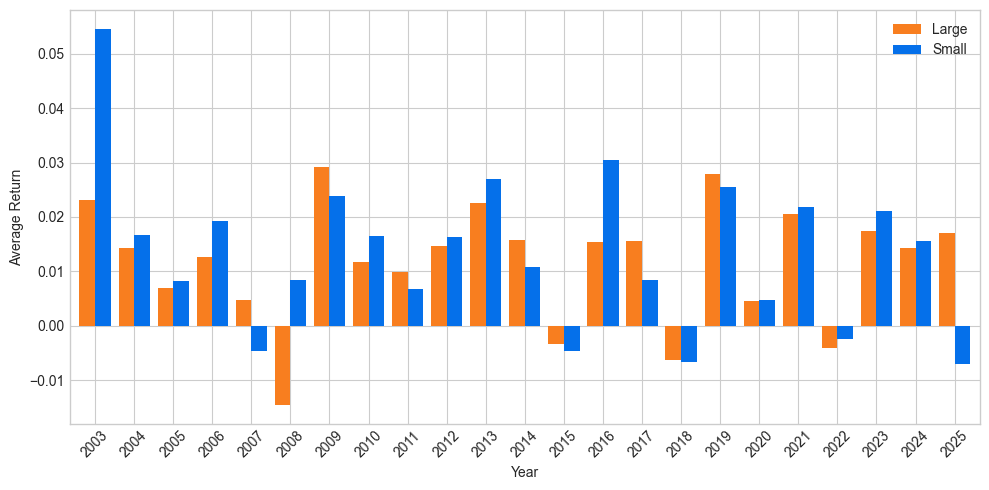

In [ ]:
#| label: fig-size_factor
#| align: center
#| fig-cap: "**The size factor**: average returns of smaller versus larger firms."
size_returns = compute_size_portfolios(data_ml)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
size_pivot = size_returns.pivot(index='year', columns='large', values='R1M')
size_pivot.plot(kind='bar', ax=ax, color=['#F87E1F', '#0570EA'], width=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Average Return')
ax.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Factors

The construction of so-called factors follows the same lines as above. Portfolios are based on one characteristic and the factor is a long-short ensemble of one extreme portfolio minus the opposite extreme (small minus large for the size factor or high book-to-market ratio minus low book-to-market ratio for the value factor). Sometimes, subtleties include forming bivariate sorts and aggregating several portfolios together, as in the original contribution of {cite:t}`fama1993common`. The most common factors are listed below, along with a few references. We refer to the books listed at the beginning of the chapter for a more exhaustive treatment of factor idiosyncrasies. For most anomalies, theoretical justifications have been brought forward, whether risk-based or behavioral. We list the most frequently cited factors below:

- Size (**SMB** = small firms minus large firms): {cite:t}`banz1981relationship`, {cite:t}`fama1992cross`, {cite:t}`fama1993common`, {cite:t}`van2011size`, {cite:t}`asness2018size` and {cite:t}`astakhov2019firm`.
- Value (**HML** = high minus low: undervalued minus growth firms): {cite:t}`fama1992cross`, {cite:t}`fama1993common`, {cite:t}`asness2013devil`.
- Momentum (**WML** = winners minus losers): {cite:t}`jegadeesh1993returns`, {cite:t}`carhart1997persistence` and {cite:t}`asness2013devil`. The winners are the assets that have experienced the highest returns over the last year (sometimes the computation of the return is truncated to omit the last month). Cross-sectional momentum is linked, but not equivalent, to time series momentum (trend following), see e.g., {cite:t}`moskowitz2012time` and {cite:t}`lemperiere2014two`. Momentum is also related to contrarian movements that occur both at higher and lower frequencies (short-term and long-term reversals), see {cite:t}`luo2020momentum`.
- Profitability (**RMW** = robust minus weak profits): {cite:t}`fama2015five`, {cite:t}`bouchaud2019sticky`. In the former reference, profitability is measured as (revenues - (cost and expenses))/equity.
- Investment (**CMA** = conservative minus aggressive): {cite:t}`fama2015five`, {cite:t}`hou2015digesting`. Investment is measured via the growth of total assets (divided by total assets). Aggressive firms are those that experience the largest growth in assets.
- Low risk (sometimes, **BAB** = betting against beta): {cite:t}`ang2006cross`, {cite:t}`baker2011benchmarks`, {cite:t}`frazzini2014betting`, {cite:t}`boloorforoosh2019beta`, {cite:t}`baker2019leverage` and {cite:t}`asness2020betting`. In this case, the computation of risk changes from one article to the other (simple volatility, market beta, idiosyncratic volatility, etc.).   
- Green (**GMB** = green minus brown): {cite:t}`pastor2021sustainable`, {cite}`lioui2022chasing`, see also {cite:t}`coqueret2022perspectives` for an early review on sustainable equity investing. This subject, the greenium, has become so vast that it is impossible to review thoroughly.

With the notable exception of the low risk premium and the greenium, the most mainstream anomalies are kept and updated in the data library of Kenneth French (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). Of course, the computation of the factors follows a particular set of rules, but they are generally accepted in the academic sphere. Another source of data is the AQR repository: https://www.aqr.com/Insights/Datasets.

In the dataset we use for the book, we proxy the value anomaly not with the book-to-market ratio but with the price-to-book ratio (the book value is located in the denominator). As is shown in {cite:t}`asness2013devil`, the choice (and timing) of the variable for value can have sizable effects.

Below, we import data from Ken French’s data library. We will use it later on in the chapter.

In [ ]:
#| label: fig-FF_returns
#| fig-cap: "Snapshot of Fama-French factor returns. Source: Ken French library."
#| fig-align: center
min_date = pd.to_datetime('1963-07-01')
max_date = pd.to_datetime('2024-03-01')
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp"
ff_url += "/F-F_Research_Data_5_Factors_2x3_CSV.zip"
# Create the download url
df_ff = pd.read_csv(ff_url, sep=',', skiprows=3, quotechar='"')
df_ff.rename(columns = {'Unnamed: 0':'date'},
             inplace = True) # renaming for clarity
df_ff.rename(columns = {'Mkt-RF':'MKT_RF'},
             inplace = True) # renaming for clarity
df_ff = df_ff.iloc[0:743, :]    
df_ff['date'] = pd.to_datetime(df_ff['date'], format='%Y%m')  
df_ff["date"] = df_ff["date"] + pd.DateOffset(months=1) - pd.Timedelta(days=1)       
df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']] = df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']].apply(pd.to_numeric)
df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']]=df_ff[
    ['MKT_RF','SMB','HML','RMW','CMA','RF']].values/100.0 # Scale returns
idx_ff=df_ff.index[(df_ff['date']>=min_date)&(
    df_ff['date']<=max_date)].tolist()
FF_factors=df_ff.iloc[idx_ff].copy()
FF_factors.loc[:,'year']=FF_factors.date.astype(str).str[:4]
FF_factors.iloc[1:6,0:7].head()

,date,MKT_RF,SMB,HML,RMW,CMA,RF
1,1963-08-31,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0025
2,1963-09-30,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0027
3,1963-10-31,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0029
4,1963-11-30,-0.0086,-0.0085,0.0173,-0.0043,0.0227,0.0027
5,1963-12-31,0.0183,-0.0189,-0.0021,0.0012,-0.0025,0.0029


Posterior to the discovery of these stylized facts, some contributions have aimed at building theoretical models that capture these properties. Theorizing a posteriori is sometimes called HARKing (see {cite:t}`kerr1998harking` and {cite:t}`hollenbeck2017harking`). We cite a handful below:

- **size** and **value**: {cite:t}`berk1999optimal`, {cite:t}`daniel2001overconfidence`, {cite:t}`barberis2003style`, {cite:t}`gomes2003equilibrium`, {cite:t}`carlson2004corporate`, {cite:t}`arnott2014can`;
- **momentum**: {cite:t}`johnson2002rational`, {cite:t}`grinblatt2005prospect`, {cite:t}`vayanos2013institutional`, {cite:t}`choi2014momentum`.

In addition, bridges have also been built between risk-based factor representations and behavioural theories. We refer essentially to {cite:t}`barberis2016prospect` and {cite:t}`daniel2019short` and the references therein.

While these factors (i.e., long-short portfolios) exhibit time-varying risk premia and are magnified by corporate news and announcements ({cite:t}`engelberg2018anomalies`), it is well-documented (and accepted) that they deliver positive returns over long horizons. We refer to {cite:t}`gagliardini2016time` and to the survey {cite:t}`gagliardini2019estimation`, as well as to the related bibliography for technical details on estimation procedures of risk premia and the corresponding empirical results. A large sample study that documents regime changes in factor premia was also carried out by {cite:t}`ilmanen2019factor`. Moreover, the predictability of returns is also time-varying (as documented in {cite:t}`farmer2019pockets`, {cite:t}`tsiakas2020equity` and {cite:t}`liu2020can`), and estimation methods can be improved ({cite:t}`johnson2019fresh`).

In [](#fig-return_anomalies), we plot the average monthly return aggregated over each calendar year for five common factors and the risk-free rate. The risk free rate (which is not a factor per se) is the most stable, while the market factor (aggregate market returns minus the risk-free rate) is the most volatile. This makes sense because it is the only long equity factor among the five series.

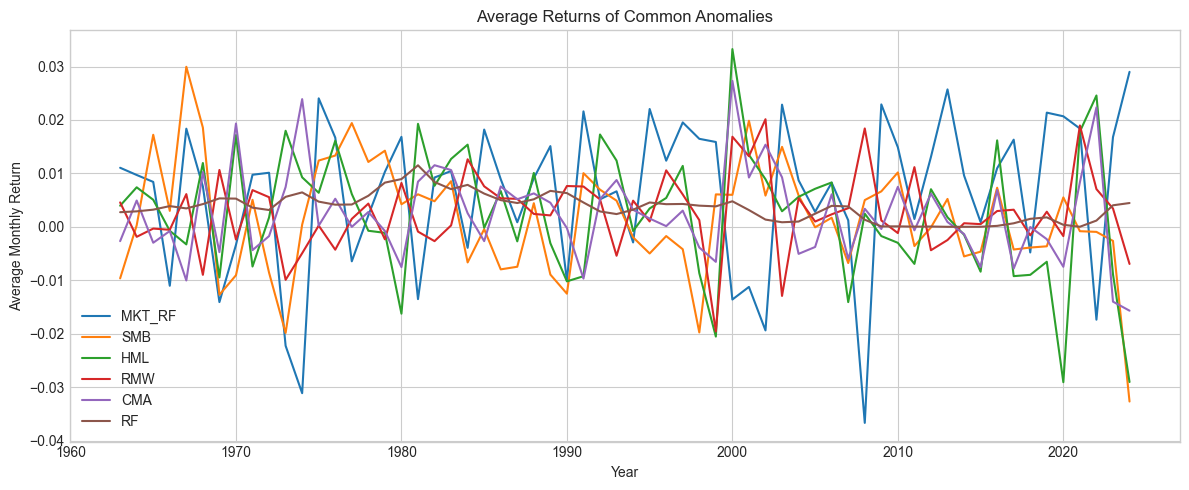

In [ ]:
#| label: fig-return_anomalies
#| fig-cap: "Average returns of common anomalies plus the risk-free rate (1963-2024). Source: Ken French library."
# Plot average annual returns for Fama-French factors
FF_annual = FF_factors.copy()
FF_annual['year'] = FF_annual['date'].dt.year

# Melt to long format
factors_to_plot = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
FF_long = FF_annual.melt(
    id_vars=['year'], 
    value_vars=factors_to_plot,
    var_name='factor', 
    value_name='return'
)

# Compute annual average
FF_avg = FF_long.groupby(['year', 'factor'])['return'].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
for factor in factors_to_plot:
    subset = FF_avg[FF_avg['factor'] == factor]
    ax.plot(subset['year'], subset['return'], label=factor)

ax.set_xlabel('Year')
ax.set_ylabel('Average Monthly Return')
ax.set_title('Average Returns of Common Anomalies')
ax.legend()
plt.tight_layout()
plt.show()

The individual attributes of investors who allocate towards particular factors is a blossoming topic. We list a few references below, even though they somewhat lie out of the scope of this book. {cite:t}`betermier2017value` show that value investors are older, wealthier and face lower income risk compared to growth investors who are those in the best position to take financial risks. The study {cite:t}`cronqvist2015value` leads to different conclusions: it finds that the propensity to invest in value versus growth assets has roots in genetics and in life events (the latter effect being confirmed in {cite:t}`cocco2019evidence`, and the former being further detailed in a more general context in {cite:t}`cronqvist2015value`). Psychological traits can also explain some factors: when agents extrapolate, they are likely to fuel momentum (this topic is thoroughly reviewed in {cite:t}`barberis2018psychology`). Micro- and macro-economic consequences of these preferences are detailed in {cite:t}`bhamra2019does`. To conclude this paragraph, we mention that theoretical models have also been proposed that link agents’ preferences and beliefs (via prospect theory) to market anomalies (see for instance {cite:t}`du2020deep`).

Finally, we highlight the need of replicability of factor premia and echo the recent editorial by {cite:t}`harvey2019evaluation`. As is shown by {cite:t}`linnainmaa2018history` and {cite:t}`hou2019replicating`, many proclaimed factors are in fact very much data-dependent and often fail to deliver sustained profitability when the investment universe is altered or when the definition of variable changes ({cite:t}`asness2013devil`).

Campbell Harvey and his co-authors, in a series of papers, tried to synthesize the research on factors in {cite:t}`harvey2016and`, {cite:t}`harvey2017lucky` and {cite:t}`harvey2017lucky`. This work underlines the need to set high bars for an anomaly to be called a ‘true’ factor. Increasing thresholds for $p$-values is only a partial answer, as it is always possible to resort to data snooping in order to find an optimized strategy that will fail out-of-sample but that will deliver a $t$-statistic larger than three (or even four). {cite:t}`harvey2017presidential` recommends to resort to a Bayesian approach which blends data-based significance with a prior into a so-called Bayesianized *p*-value (see subsection below).

Following this work, researchers have continued to explore the richness of this zoo. {cite:t}`bryzgalova2019spurious` propose a tractable Bayesian estimation of large-dimensional factor models and evaluate all possible combinations of more than 50 factors, yielding an incredibly large number of coefficients. This combined with a {cite:t}`fama1973risk` procedure allows to distinguish between pervasive and superfluous factors. {cite:t}`chordia2020anomalies` use simulations of 2 million trading strategies to estimate the rate of *false discoveries*, that is, when a spurious factor is detected (type I error). They also advise to use thresholds for t-statistics that are well above three. In a similar vein, {cite:t}`harvey2019false` also underline that sometimes *true* anomalies may be missed because of a one time $t$-statistic that is too low (type II error).

The propensity of journals to publish positive results has led researchers to estimate the difference between reported returns and *true* returns. {cite:t}`chen2020limits` call this difference the *publication bias* and estimate it as roughly 12%. That is, if a published average return is 8%, the actual value may in fact be closer to (1-12%)*8%=7%. Qualitatively, this estimation of 12% is smaller than the out-of-sample reduction in returns found in {cite:t}`mclean2016does`.

### Predictive regressions, sorts, and p-value issues

For simplicity, we assume a simple form for stock returns (written in compact form):

```{math}
:label: r
\textbf{r} = a+b\textbf{x}+\textbf{e},
```

where the vector $\textbf{r}$ stacks all returns of all stocks and $\textbf{x}$ is a lagged variable so that the regression is indeed predictive. If the estimated $\hat{b}$ is significant given a specified confidence threshold, then it can be tempting to conclude that $\textbf{x}$ does a good job at predicting returns. Hence, long-short portfolios related to extreme values of $\textbf{x}$ (mind the sign of $\hat{b}$) are expected to generate profits. This is unfortunately often false because $\hat{b}$ gives information on the *past* ability of $\textbf{x}$ to forecast returns. What happens in the future may be another story. In fact, as we discuss later, the problem is that it is mostly correlation that can be captured from financial data, whereas one would ideally prefer to infer *causality* (see, e.g., {cite:t}`de2026correcting`).

Statistical tests are also used for portfolio sorts. Assume two extreme portfolios are expected to yield very different average returns (like very small cap versus very large cap, or strong winners versus bad losers). The portfolio returns are written $r_t^+$ and $r_t^-$. The simplest test for the mean is $t=\sqrt{T}\frac{m_{r_+}-m_{r_-}}{\sigma_{r_+-r_-}}$, where $T$ is the number of points and $m_{r_\pm}$ denotes the means of returns and $\sigma_{r_+-r_-}$ is the standard deviation of the difference between the two series, i.e., the volatility of the long-short portfolio. In short, the statistic can be viewed as a scaled Sharpe ratio (though usually these ratios are computed for long-only portfolios) and can in turn be used to compute $p$-values to assess the robustness of an anomaly. As is shown in {cite:t}`linnainmaa2018history` and {cite:t}`hou2019replicating`, many factors discovered by reasearchers fail to survive in out-of-sample tests.

One reason why people are overly optimistic about anomalies they detect is the widespread reverse interpretation of the p-value. Often, it is thought of as the probability of one hypothesis (e.g., my anomaly exists) given the data. In fact, it’s the opposite; it’s the likelihood of your data sample, knowing that the anomaly holds.

\begin{align*}
p-\text{value} &= P[D|H] \\
\text{target prob.}& = P[H|D]=\frac{P[D|H]}{P[D]}\times P[H],
\end{align*}

where $H$ stands for hypothesis and $D$ for data. The equality in the second row is a plain application of Bayes’ identity: the interesting probability is in fact a transform of the $p$-value.

Two articles (at least) discuss this idea. {cite:t}`harvey2017presidential` introduces **Bayesianized** $p$-values:

```{math}

:label: bayes_pvalue
\text{Bayesianized } p-\text{value}=\text{Bpv}= e^{-t^2/2}\times\frac{\text{prior}}{1+e^{-t^2/2}\times \text{prior}} ,

```

where $t$ is the $t$-statistic obtained from the regression (i.e., the one that defines the p-value) and prior is the analyst’s estimation of the odds that the hypothesis (anomaly) is true. The prior is coded as follows. Suppose there is a p% chance that the null holds (i.e., (1-p)% for the anomaly). The odds are coded as $p/(1-p)$. Thus, if the t-statistic is equal to 2 (corresponding to a p-value of 5% roughly) and the prior odds are equal to 6, then the Bpv is equal to $e^{-2}\times 6 \times(1+e^{-2}\times 6)^{-1}\approx 0.448$ and there is a 44.8% chance that the null is true. This interpretation stands in sharp contrast with the original $p$-value which cannot be viewed as a probability that the null holds. Of course, one drawback is that the level of the prior is crucial and solely user-specified.

The work of {cite:t}`chinco2019estimating` is very different but shares some key concepts, like the introduction of Bayesian priors in regression outputs. They show that coercing the predictive regression with an $L^2$ constraint (see the ridge regression in Chapter 5) amounts to introducing views on what the true distribution of $b$ is. The stronger the constraint, the more the estimate $\hat{b}$ will be shrunk towards zero. One key idea in their work is the assumption of a distribution for the true $b$ across many anomalies. It is assumed to be Gaussian and centered. The interesting parameter is the standard deviation: the larger it is, the more frequently significant anomalies are discovered. Notably, the authors show that this parameter changes through time and we refer to the original paper for more details on this subject.

### Fama-Macbeth regressions

Another approach (one of the first in fact) was proposed by {cite:t}`fama1973risk` through a two-stage regression analysis of risk premia. The first stage is a simple estimation of the relationship (): the regressions are run on a stock-by-stock basis over the corresponding time series. The resulting estimates $\hat{\beta}_{i,k}$ are then plugged into a second series of regressions:

\begin{align*}
r_{t,n}= \gamma_{t,0} + \sum_{k=1}^K\gamma_{t,k}\hat{\beta}_{n,k} + \varepsilon_{t,n},
\end{align*}

which are run date-by-date on the cross-section of assets. Theoretically, the betas would be known and the regression would be run on the $\beta_{n,k}$ instead of their estimated values. The $\hat{\gamma}_{t,k}$ estimate the premia of factor $k$ at time $t$. Under suitable distributional assumptions on the $\varepsilon_{t,n}$, statistical tests can be performed to determine whether these premia are significant or not. Typically, the statistic on the time-aggregated (average) premia $\hat{\gamma}_k=\frac{1}{T}\sum_{t=1}^T\hat{\gamma}_{t,k}$:

\begin{align*}
t_k=\frac{\hat{\gamma}_k}{\hat{\sigma_k}/\sqrt{T}}
\end{align*}

is often used (under Gaussian assumptions) to assess whether or not the factor is significant ($\hat{\sigma}_k$ is the standard deviation of the $\hat{\gamma}_{t,k}$).

We refer to {cite:t}`jagannathan1998asymptotic` and {cite:t}`petersen2009estimating` for technical discussions on the biases and losses in accuracy that can be induced by standard ordinary least squares (OLS) estimations. Moreover, as the $\hat\beta_{i,k}$ in the second-pass regression are estimates, a second level of errors can arise (the so-called errors in variables). The interested reader will find some extensions and solutions in {cite:t}`shanken1992estimation`, {cite:t}`ang2018using` and {cite:t}`jegadeesh2019empirical`. There even exists a three-pass method (see {cite:t}`giglio2018asset`).

Below, we perform {cite:t}`fama1973risk` regressions on our sample. We start by the first pass: individual estimation of betas. We first build a dedicated dataset.

In [ ]:
# Select a subset of stocks for the Fama-MacBeth analysis
stock_ids_short = data_ml['fsym_id'].unique()[:30]

# Prepare data: merge returns with factors
returns_subset = data_ml[data_ml['fsym_id'].isin(stock_ids_short)][['date', 'fsym_id', 'R1M']]
returns_pivot = returns_subset.pivot(index='date', columns='fsym_id', values='R1M')

# Merge with factors
data_FM = returns_pivot.join(FF_factors.set_index('date')[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']])

# Select a subset of stocks for the Fama-MacBeth analysis
stock_ids_short = data_ml['fsym_id'].unique()[:30]

# Prepare data: merge returns with factors
returns_subset = data_ml[data_ml['fsym_id'].isin(stock_ids_short)][['date', 'fsym_id', 'R1M']]
returns_pivot = returns_subset.pivot(index='date', columns='fsym_id', values='R1M')

# Merge with factors
data_FM = returns_pivot.join(FF_factors.set_index('date')[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']])
data_FM = data_FM.dropna()

print(f"Data shape for FM regressions: {data_FM.shape}")

Next, we loop across stocks. 

In [ ]:
#| label: tab-sample-betas
#| fig-cap: "Sample of beta values."
# First pass: estimate betas for each stock
factor_cols = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']
betas = {}

for fsym_id in stock_ids_short:
    if fsym_id in data_FM.columns:
        y = data_FM[fsym_id].shift(-1).dropna()  # Lagged returns
        X = data_FM[factor_cols].loc[y.index]
        X = sm.add_constant(X)
        
        # Drop any remaining NaN
        mask = ~(y.isna() | X.isna().any(axis=1))
        y_clean = y[mask]
        X_clean = X[mask]
        
        if len(y_clean) > 10:  # Minimum observations
            model = sm.OLS(y_clean, X_clean).fit()
            betas[fsym_id] = model.params

# Convert to DataFrame
betas_df = pd.DataFrame(betas).T
betas_df.columns = ['Constant'] + factor_cols
betas_df.head(6).round(3)

,Constant,MKT_RF,SMB,HML,RMW,CMA
BV3N5V-R,0.012,0.373,-0.479,-0.097,-0.484,0.651
BZPTB8-R,0.014,0.277,-0.552,-0.375,-0.371,0.332
CHKL7S-R,0.015,0.078,-0.307,-0.096,-0.093,0.502
CPCV0Y-R,0.014,0.170,-0.380,-0.474,-0.057,0.676
CSMTMQ-R,0.006,-0.110,0.103,-0.307,0.283,0.591
CYBC69-R,0.010,0.002,0.066,-0.329,0.141,0.233


In the table, MKT_RF is the market return minus the risk free rate. The corresponding coefficient is often referred to as the beta, especially in univariate regressions. We then reformat these betas from the table to prepare the second pass. Each line corresponds to one asset: the first 5 columns are the estimated factor loadings and the remaining ones are the asset returns (date by date).

In [80]:
#| label: tab-sample-gammas
#| fig-cap: "Sample of gamma (premia) values."
# Second pass: cross-sectional regressions
# Prepare data: loadings (betas) and returns
loadings = betas_df[factor_cols]
returns_for_FM = returns_pivot[loadings.index].T  # Transpose: stocks as rows, dates as columns

# Run cross-sectional regressions for each date
gammas = {}

for date in returns_for_FM.columns:
    y = returns_for_FM[date].dropna()
    X = loadings.loc[y.index]
    X = sm.add_constant(X)
    
    if len(y) > 5:  # Minimum observations
        model = sm.OLS(y, X).fit()
        gammas[date] = model.params

# Convert to DataFrame
gammas_df = pd.DataFrame(gammas).T
gammas_df.columns = ['Constant'] + factor_cols
gammas_df.head(6).round(3)

,Constant,MKT_RF,SMB,HML,RMW,CMA
2003-02-28,-0.044,-0.169,-0.046,-0.096,0.011,-0.007
2003-03-31,0.029,0.072,0.102,0.024,0.046,0.016
2003-04-30,0.100,0.189,-0.063,0.015,-0.010,-0.038
2003-05-31,0.067,-0.047,-0.111,-0.081,-0.037,-0.048
2003-06-30,0.009,0.185,0.066,0.103,-0.071,0.042
2003-07-31,0.053,0.004,0.122,0.278,-0.055,0.110


Visually, the estimated premia are also very volatile. We plot their estimated values for the market, SMB and HML factors.

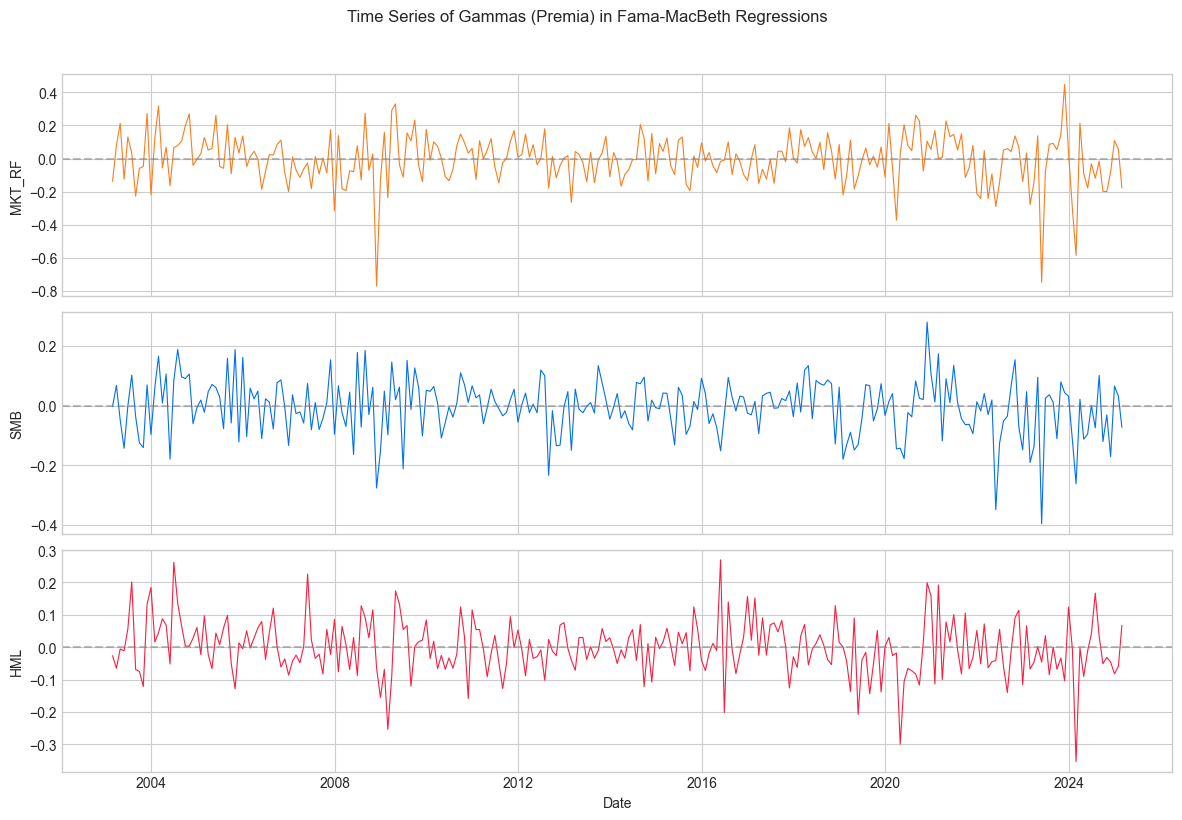

In [ ]:
#| label: fig-ts-gammas
#| fig-cap: "Time-series of gamma values (premia)."
# Plot time series of gammas (premia)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

factors_plot = ['MKT_RF', 'SMB', 'HML']
colors = ['#F87E1F', '#0570EA', '#F81F40']

for ax, factor, color in zip(axes, factors_plot, colors):
    ax.plot(gammas_df.index, gammas_df[factor], color=color, linewidth=0.8)
    ax.set_ylabel(factor)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Date')
fig.suptitle('Time Series of Gammas (Premia) in Fama-MacBeth Regressions', y=1.02)
plt.tight_layout()
plt.show()

### Factor competition

The core purpose of factors is to explain the cross-section of stock returns. For theoretical and practical reasons, it is preferable if redundancies within factors are avoided. Indeed, redundancies imply collinearity which is known to perturb estimates ({cite:t}`belsley2005regression`). In addition, when asset managers decompose the performance of their returns into factors, overlaps (high absolute correlations) between factors yield exposures that are less interpretable; positive and negative exposures compensate each other spuriously.

A simple protocol to sort out redundant factors is to run regressions of each factor against all others:

```{math}
:label: f_competition
f_{t,k} = a_k +\sum_{j\neq k} \delta_{k,j} f_{t,j} + \epsilon_{t,k}.
```

The interesting metric is then the test statistic associated to the estimation of $a_k$. If $a_k$ is significantly different from zero, then the cross-section of (other) factors fails to explain exhaustively the average return of factor $k$. Otherwise, the return of the factor can be captured by exposures to the other factors and is thus redundant.

One mainstream application of this technique was performed in {cite:t}`fama2015five`, in which the authors show that the HML factor is redundant when taking into account four other factors (Market, SMB, RMW and CMA). Below, we reproduce their analysis on an updated sample. We start our analysis directly with the database maintained by Kenneth French.

We can run the regressions that determine the redundancy of factors via the procedure defined in Equation [](#f_competition).

In [ ]:
#| label: fig-factor_competition
#| fig-cap: "Factor Competition among the five Fama-French Factors."
#| fig-align: center
# Factor competition analysis
factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']

def get_significance(p):
    if p < 0.001:
        return ' (***)'
    elif p < 0.01:
        return ' (**)'
    elif p < 0.05:
        return ' (*)'
    else:
        return ''

results = []
for dep_var in factors:
    other_factors = [f for f in factors if f != dep_var]
    
    y = FF_factors[dep_var]
    X = FF_factors[other_factors]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    row = {'Dep. Variable': dep_var}
    
    coef = model.params['const']
    pval = model.pvalues['const']
    row['Intercept'] = f"{coef:.3f}" + get_significance(pval)
    
    for factor in factors:
        if factor == dep_var:
            row[factor] = '-'
        else:
            coef = model.params[factor]
            pval = model.pvalues[factor]
            row[factor] = f"{coef:.3f}" + get_significance(pval)
    
    results.append(row)

factor_competition_df = pd.DataFrame(results)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
factor_competition_df

Significance: *** p<0.001, ** p<0.01, * p<0.05


,Dep. Variable,Intercept,MKT_RF,SMB,HML,RMW,CMA
0,MKT_RF,0.008 (***),-,0.292 (***),0.114,-0.256 (***),-0.855 (***)
1,SMB,0.002 (*),0.136 (***),-,0.156 (**),-0.445 (***),-0.183 (*)
2,HML,-0.001,0.032,0.094 (**),-,0.179 (***),1.030 (***)
3,RMW,0.004 (***),-0.066 (***),-0.247 (***),0.165 (***),-,-0.256 (***)
4,CMA,0.002 (***),-0.105 (***),-0.048 (*),0.453 (***),-0.122 (***),-


We obtain the vector of $α$ values from Equation [](#f_competition). Below, we format these figures along with $p$-value thresholds and export them in a summary table. The significance levels of coefficients is coded as follows: $0<(***)<0.001<(**)<0.01<(*)<0.05$

We confirm that the HML factor remains redundant when the four others are present in the asset pricing model (its alpha is not significantly different from zero). The figures we obtain are reasonably close to the ones in the original paper ({cite:t}`fama2015five`), which makes sense, since we only add 10 years to their initial sample.

At a more macro-level, researchers also try to figure out which models (i.e., combinations of factors) are the most likely, given the data empirically observed (and possibly given priors formulated by the econometrician). For instance, this stream of literature seeks to quantify to which extent the 3-factor model of {cite:t}`fama1993common` outperforms the 5 factors in {cite:t}`fama2015five`. In this direction, {cite:t}`de2015comparing` introduce a novel computation for p-values that compare the relative likelihood that two models pass a zero-alpha test. More generally, the Bayesian method of {cite:t}`barillas2018comparing` was subsequently improved by {cite:t}`chib2021winners`.

Lastly, even the optimal **number of factors** is a subject of disagreement among conclusions of recent work. While the traditional literature focuses on a limited number (3-5) of factors, more recent research by {cite:t}`martin2018transaction`, {cite:t}`he2019factors`, {cite:t}`kozak2019shrinking` and {cite:t}`freyberger2020dissecting` advocates the need to use at least 15 or more. {cite:t}`kozak2019shrinking` provide perhaps the strongest counter-evidence, arguing that "*the quest for a sparse characteristics-based factor model is ultimately futile*" since such models fail out-of-sample. A middle ground emerges from {cite:t}`kelly2019characteristics`, who find only 10 characteristics (or **latent** factors) significant in their IPCA framework, and {cite:t}`swade2024factor`, who conclude that approximately 15 factors span the zoo—more than traditional models but far fewer than hundreds. The synthesis suggests that while extreme factor proliferation reflects data mining (see {cite:t}`chen2024does`), traditional 3–6 factor models likely underfit the true complexity; dimension reduction to 10–15 factors or latent components offers the best balance between overfitting and explanatory power. {cite:t}`green2017characteristics` even find that the number of characteristics that help explain the cross-section of returns varies in time.

### Advanced techniques

The ever increasing number of factors combined to their importance in asset management has led researchers to craft more subtle methods in order to   organize’’ the so-called factor zoo and, more importantly, to detect spurious anomalies and compare different asset pricing model specifications. We list a few of them below. - {cite:t}`feng2019taming` combine LASSO selection with Fama-MacBeth regressions to test if new factor models are worth it. They quantify the gain of adding one new factor to a set of predefined factors and show that many factors reported in papers published in the 2010 decade do not add much incremental value;

-  C. {cite:t}`harvey2017lucky` (in a similar vein) use bootstrap on orthogonalized factors. They make the case that correlations among predictors is a major issue and their method aims at solving this problem. Their lengthy procedure seeks to test if maximal additional contribution of a candidate variable is significant;
-  {cite:t}`fama2018choosing` compare asset pricing models through squared maximum Sharpe ratios;
-  {cite:t}`giglio2018asset` estimate factor risk premia using a three-pass method based on principal component analysis;
-  {cite:t}`pukthuanthong2018protocol` disentangle priced and non-priced factors via a combination of principal component analysis and {cite:t}`fama1973risk` regressions;
-  {cite:t}`gospodinov2019too` warn against factor misspecification (when spurious factors are included in the list of regressors). Traded factors ($resp$. macro-economic factors) seem more likely ($resp$. less likely) to yield robust identifications (see also {cite:t}`bryzgalova2019spurious`).

There is obviously no infallible method, but the number of contributions in the field highlights the need for robustness. This is evidently a major concern when crafting investment decisions based on factor intuitions. One major hurdle for short-term strategies is the likely time-varying feature of factors. We refer for instance to {cite:t}`ang2012testing` and {cite:t}`cooper2018new` for practical results and to {cite:t}`gagliardini2016time` and S. {cite:t}`ma2018testing` for more theoretical treatments (with additional empirical results).

## Factors or characteristics?

The decomposition of returns into linear factor models is convenient because of its simple interpretation. There is nonetheless a debate in the academic literature about whether firm returns are indeed explained by exposure to macro-economic factors or simply by the characteristics of firms. In their early study, {cite:t}`lakonishok1994contrarian` argue that one explanation of the value premium comes from incorrect extrapolation of past earning growth rates. Investors are overly optimistic about firms subject to recent profitability. Consequently, future returns are (also) driven by the core (accounting) features of the firm. The question is then to disentangle which effect is the most pronounced when explaining returns: characteristics versus exposures to macro-economic factors.

In their seminal contribution on this topic, {cite:t}`daniel1997evidence` provide evidence in favour of the former (two follow-up papers are K. {cite:t}`daniel2001overconfidence` and {cite:t}`daniel2012testing`). They show that firms with high book-to-market ratios or small capitalizations display higher average returns, even if they are negatively loaded on the HML or SMB factors. Therefore, it seems that it is indeed the intrinsic characteristics that matter, and not the factor exposure. For further material on characteristics’ role in return explanation or prediction, we refer to the following contributions: - Section 2.5.2. in {cite:t}`goyal2012empirical` surveys pre-2010 results on this topic;
- {cite:t}`chordia2015cross` find that characteristics explain a larger proportion of variation in estimated expected returns than factor loadings;
- {cite:t}`kozak2018interpreting` reconcile factor-based explanations of premia to a theoretical model in which some agents’ demands are sentiment driven;
- {cite:t}`han2018firm` show with penalized regressions that 20 to 30 characteristics (out of 94) are useful for the prediction of monthly returns of US stocks. Their methodology is interesting: they regress returns against characteristics to build forecasts and then regress the returns on the forecast to assess if they are reliable. The latter regression uses a LASSO-type penalization (see Chapter 5) so that useless characteristics are excluded from the model. The penalization is extended to elasticnet in {cite:t}`rapach2019time`.
- {cite:t}`kelly2019characteristics` and {cite:t}`kim2019arbitrage` both estimate models in which factors are latent but loadings (betas) and possibly alphas depend on characteristics. {cite:t}`kirby2020firm` generalizes the first approach by introducing regime-switching. In contrast, {cite:t}`lettau2018estimating` and {cite:t}`lettau2018estimating` estimate latent factors without any link to particular characteristics (and provide large sample asymptotic properties of their methods).
- In the same vein as {cite:t}`hoechle2018correcting`, {cite:t}`gospodinov2019too` and {cite:t}`bryzgalova2019spurious` and discuss potential errors that arise when working with portfolio sorts that yield long-short returns. The authors show that in some cases, tests based on this procedure may be deceitful. This happens when the characteristic chosen to perform the sort is correlated with an external (unobservable) factor. They propose a novel regression-based approach aimed at bypassing this problem.

More recently and in a separate stream of literature, R. {cite:t}`koijen2019investors` have introduced a demand model in which investors form their portfolios according to their preferences towards particular firm characteristics. They show that this allows them to mimic the portfolios of large institutional investors. In their model, aggregate demands (and hence, prices) are directly linked to characteristics, not to factors. In a follow-up paper, {cite:t}`koijen2019investors` show that a few sets of characteristics suffice to predict future returns. They also show that, based on institutional holdings from the UK and the US, the largest investors are those who are the most influencial in the formation of prices. In a similar vein, {cite:t}`betermier2019supply` derive an elegant (theoretical) general equilibrium model that generates some well-documented anomalies (size, book-to-market). The models of {cite:t}`arnott2014can` and {cite:t}`alti2019dynamic` are also able to theoretically generate known anomalies. Finally, in I. {cite:t}`martin2019bayesian`, characteristics influence returns via the role they play in the predictability of dividend growth. This paper discussed the asymptotic case when the number of assets and the number of characteristics are proportional and both increase to infinity.

## Hot Topics: momentum, timing and ESG

### Factor momentum

A recent body of literature unveils a time series momentum property of factor returns. For instance, {cite:t}`gupta2019factor` report that autocorrelation patterns within these returns is statistically significant.7 Similar results are obtained in {cite:t}`falck2020factor`. In the same vein, Arnott et al. (2020) make the case that the industry momentum found in {cite:t}`moskowitz1999industries` can in fact be explained by this factor momentum. Going even further, {cite:t}`arnott2019alice` conclude that the original momentum factor is in fact the aggregation of the autocorrelation that can be found in all other factors. Given the data obtained on Ken French’s website, we compute the autocorrelation function (ACF) of factors. We recall that

Acknowledging the profitability of factor momentum, H. {cite:t}`yang2020decomposing` seeks to understand its source and decomposes stock factor momentum portfolios into two components: factor timing portfolio and a static portfolio. The former seeks to profit from the serial correlations of factor returns while the latter tries to harness factor premia. The author shows that it is the static portfolio that explains the larger portion of factor momentum returns. In H. {cite:t}`yang2020decomposing`, the same author presents a new estimator to gauge factor momentum predictability. Words of caution are provided in {cite:t}`leippold2021anatomy`.

{cite:t}`garcia2021factor` document factor momentum at the daily frequency.

Given the data obtained on Ken French’s website, we compute the autocorrelation function (ACF) of factors. We recall that

\begin{align*}
\text{ACF}_k(\textbf{x}_t)=\mathbb{E}[(\textbf{x}_t-\bar{\textbf{x}})(\textbf{x}_{t+k}-\bar{\textbf{x}})].
\end{align*}

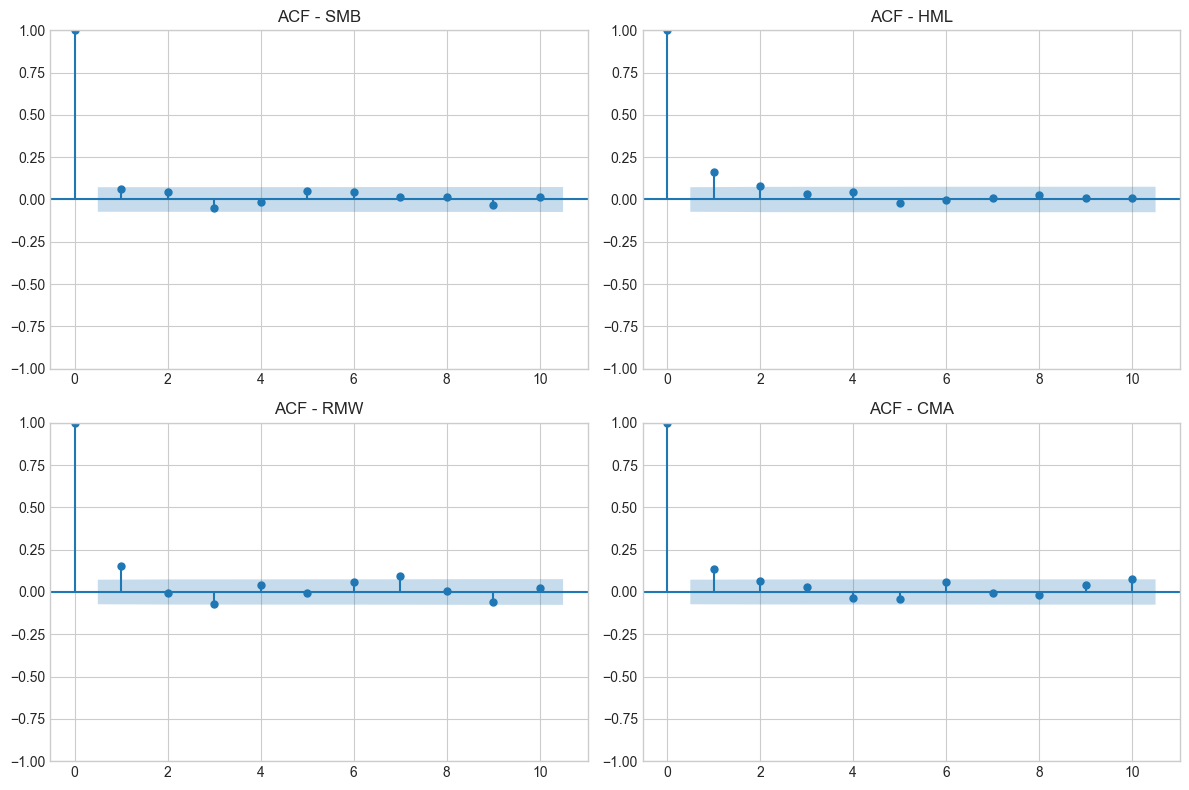

In [69]:
# ACF plots for factor returns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

factors_acf = ['SMB', 'HML', 'RMW', 'CMA']

for ax, factor in zip(axes.flatten(), factors_acf):
    plot_acf(FF_factors[factor].dropna(), ax=ax, lags=10, title=f'ACF - {factor}')

plt.tight_layout()
plt.show()

FIGURE 3.4: Autocorrelograms of common factor portfolios.

Of the four chosen series, only the size factor is not significantly autocorrelated at the first order.

### Factor timing

Given the abundance of evidence of the time-varying nature of factor premia, it is legitimate to wonder if it is possible to predict when factor will perform well or badly. The evidence on the effectiveness of timing is diverse: positive for {cite:t}`greenwood2012share`, {cite:t}`hodges2017factor`, {cite:t}`hasler2019should`, {cite:t}`haddad2020economics` and {cite:t}`lioui2020factor`, negative for {cite:t}`asness2017contrarian` and mixed for {cite:t}`dichtl2019optimal`. There is no consensus on which predictors to use (general macroeconomic indicators in {cite:t}`hodges2017factor`, stock issuances versus repurchases in {cite:t}`greenwood2012share`, and aggregate fundamental data in {cite:t}`dichtl2019optimal`). A method for building reasonable timing strategies for long-only portfolios with sustainable transaction costs is laid out in {cite:t}`leippold2020fama`. In ML-based factor investing, it is possible to resort to more granularity by combining firm-specific attributes to large-scale economic data as we explain in Section 4.7.2.

### The green factors

The demand for ethical financial products has sharply risen during the 2010 decade, leading to the creation of funds dedicated to socially responsible investing (SRI - see {cite:t}`camilleri2020market`). Though this phenomenon is not really new ({cite:t}`schueth2003socially`, {cite:t}`hill2007corporate`), its acceleration has prompted research about whether or not characteristics related to ESG criteria (environment, social, governance) are priced. Dozens and even possibly hundreds of papers have been devoted to this question, but no consensus has been reached. More and more, researchers study the financial impact of climate change (see {cite:t}`bernstein2019disaster`, {cite:t}`hong2019climate` and {cite:t}`hong2020climate`) and the societal push for responsible corporate behavior ({cite:t}`fabozzi2020introduction`, {cite:t}`kurtz2020three`). We gather below a very short list of papers that suggests conflicting results:
- **favorable**: ESG investing works ({cite:t}`kempf2007effect`, {cite:t}`cheema2020decarbonization`), can work ({cite:t}`nagy2016can`, {cite:t}`alessandrini2020optimal`), or can at least be rendered efficient ({cite:t}`branch2012socially`). A large meta-study reports overwhelming favorable results ({cite:t}`friede2015esg`), but of course, they could well stem from the publication bias towards positive results.
- **unfavorable**: Ethical investing is not profitable according to {cite:t}`adler2008cost` and {cite:t}`blitz2020exclusion`. An ESG factor should be long unethical firms and short ethical ones ({cite:t}`lioui2018esg`).
- **mixed**: ESG investing may be beneficial globally but not locally ({cite:t}`chakrabarti2020time`). Portfolios relying on ESG screening do not significantly outperform those with no screening but are subject to lower levels of volatility ({cite:t}`gibson2020responsible`, {cite:t}`gougler2020factor`). As is often the case, the devil is in the details, and results depend on whether to use E, S or G ({cite:t}`bruder2019integration`).

On top of these contradicting results, several articles point towards complexities in the measurement of ESG. Depending on the chosen criteria and on the data provider, results can change drastically (see {cite:t}`galema2008stocks`, {cite:t}`berg2019aggregate` and {cite:t}`atta2020strategies`).

We end this short section by noting that of course ESG criteria can directly be integrated into ML model, as is for instance done in {cite:t}`de2020esg`.

## The links with machine learning

Given the exponential increase in data availability, the obvious temptation of any asset manager is to try to infer future returns from the abundance of attributes available at the firm level. We allude to classical data like accounting ratios and to alternative data, such as sentiment. This task is precisely the aim of Machine Learning. Given a large set of predictor variables ($\mathbf{X}$), the goal is to predict a proxy for future performance $\mathbf{y}$ through a model of the form (2.1).

Some attempts toward this direction have already been made (e.g., {cite:t}`brandt2009parametric`, {cite:t}`hjalmarsson2012characteristic`, {cite:t}`ammann2016characteristics`, {cite:t}`martin2018transaction`), but not with any ML intent or focus originally. In retrospect, these approaches do share some links with ML tools. The general formulation is the following. At time  
$T$, the agent or investor seeks to solve the following program:

\begin{align*}
\underset{\boldsymbol{\theta}_T}{\max} \ \mathbb{E}_T\left[ u(r_{p,T+1})\right] = \underset{\boldsymbol{\theta}_T}{\max} \ \mathbb{E}_T\left[ u\left(\left(\bar{\textbf{w}}_T+\textbf{x}_T\boldsymbol{\theta}_T\right)'\textbf{r}_{T+1}\right)\right] ,
\end{align*}

where $u$ is some utility function and $r_{p,T+1}=\left(\bar{\textbf{w}}_T+\textbf{x}_T\boldsymbol{\theta}_T\right)'\textbf{r}_{T+1}$ is the return of the portfolio, which is defined as a benchmark $\bar{\textbf{w}}_T$ plus some deviations from this benchmark that are a linear function of features $\textbf{x}_T\boldsymbol{\theta}_T$. The above program may be subject to some external constraints (e.g., to limit leverage).

In practice, the vector $\boldsymbol{\theta}_T$ must be estimated using past data (from $T-\tau$ to $T-1$): the agent seeks the solution of

```{math}
:label: theta_MV

\underset{\boldsymbol{\theta}_T}{\text{max}} \ \frac{1}{\tau} \sum_{t=T-\tau}^{T-1} u \left( \sum_{i=1}^{N_T}\left(\bar{w}_{i,t}+ \boldsymbol{\theta}'_T \textbf{x}_{i,t} \right)r_{i,t+1} \right)
```

on a sample of size $τ$ where $N_T$ is the number of asset in the universe. The above formulation can be viewed as a learning task in which the parameters are chosen such that the reward (average return) is maximized.

### A short list of recent references

Independent of a characteristics-based approach, ML applications in finance have blossomed, initially working with price data only and later on integrating firm characteristics as predictors. We cite a few references below, grouped by methodological approach:

- penalized quadratic programming: {cite:t}`goto2015improving`, Ban, El {cite:t}`ban2016machine` and {cite:t}`perrin2019machine`,
- regularized predictive regressions: {cite:t}`rapach2013international` and Alexander {cite:t}`chinco2019risk`,
- support vector machines: {cite:t}`cao2003support` (and the references therein),
- model comparison and/or aggregation: {cite:t}`kim2003financial`, {cite:t}`huang2005forecasting`, Matı́as and {cite:t}`reboredo2012nonlinearity`, Reboredo, Matı́as, and {cite:t}`reboredo2012nonlinearity`, {cite:t}`dunis2013hybrid`, {cite:t}`gu2018empirical` and {cite:t}`guida2018machine`. The latter two more recent articles work with a large cross-section of characteristics.

We provide more detailed lists for tree-based methods, neural networks and reinforcement learning techniques in Chapters 6, 7 and 16, respectively. Moreover, we refer to {cite:t}`ballings2015evaluating` for a comparison of classifiers and to {cite:t}`henrique2019literature` and {cite:t}`bustos2020stock` for surveys on ML-based forecasting techniques.

### Explicit connections with asset pricing models

The first and obvious link between factor investing and asset pricing is (average) return prediction. The main canonical academic reference is {cite:t}`gu2018empirical`. Let us first write the general equation and then comment on it:

```{math}
:label: panel_Gu

r_{t+1,n}=g(\textbf{x}_{t,n}) + \epsilon_{t+1}.
```


The interesting discussion lies in the differences between the above model and that of Equation (3.1). The first obvious difference is the introduction of the nonlinear function $g$: indeed, there is no reason (beyond simplicity and interpretability) why we should restrict the model to linear relationships. One early reference for nonlinearities in asset pricing kernels is {cite:t}`bansal1993no`.

More importantly, the second difference between (3.6) and (3.1) is the shift in the time index. Indeed, from an investor’s perspective, the interest is to be able to predict some information about the structure of the cross-section of assets. Explaining asset returns with synchronous factors is not useful because the realization of factor values is not known in advance. Hence, if one seeks to extract value from the model, there needs to be a time interval between the observation of the state space (which we call $\textbf{x}_{t,n}$) and the occurrence of the returns. Once the model $\hat{g}$ is estimated, the time-$t$ (measurable) value $g(\textbf{x}_{t,n})$ will give a forecast for the (average) future returns. These predictions can then serve as signals in the crafting of portfolio weights (see Chapter 12 for more on that topic).

While most studies do work with returns on the l.h.s. of (3.6), there is no reason why other indicators should not be used. Returns are straightforward and simple to compute, but they could very well be replaced by more sophisticated metrics, like the Sharpe ratio, for instance. The firms’ features would then be used to predict a risk-adjusted performance rather than simple returns.

Beyond the explicit form of Equation (3.6), several other ML-related tools can also be used to estimate asset pricing models. This can be achieved in several ways, some of which we list below.

First, one mainstream problem in asset pricing is to characterize the stochastic discount factor (SDF) $M_t$, which satisfies $\mathbb{E}_t[M_{t+1}(r_{t+1,n}-r_{t+1,f})]=0$ for any asset $n$ (see {cite:t}`cochrane2009asset`). This equation is a natural playing field for the generalized method of moment ({cite:t}`hansen1982large`): $M_t$ must be such that

```{math}
:label: GMM_SDF

\mathbb{E}[M_{t+1}R_{t+1,n}g(V_t)]=0,
```


where the instrumental variables $V_t$ are $\mathcal{F}_t$-measurable (i.e., are known at time $t$) and the capital $R_{t+1,n}$ denotes the excess return of asset $n$. In order to reduce and simplify the estimation problem, it is customary to define the SDF as a portfolio of assets (see chapter 3 in {cite:t}`back2010asset`). In Luyang {cite:t}`chen2020publication`, the authors use a generative adversarial network (GAN, see Section 7.7.1) to estimate the weights of the portfolios that are the closest to satisfy (3.7) under a strongly penalizing form.

A second approach is to try to model asset returns as linear combinations of factors, just as in (3.1). We write in compact notation

\begin{align*}
r_{t,n}=\alpha_n+\boldsymbol{\beta}_{t,n}'\textbf{f}_t+\epsilon_{t,n},
\end{align*}

and we allow the loadings $\boldsymbol{\beta}_{t,n}$ to be time-dependent. The trick is then to introduce the firm characteristics in the above equation. Traditionally, the characteristics are present in the definition of factors (as in the seminal definition of {cite:t}`fama1993common`). The decomposition of the return is made according to the exposition of the firm’s return to these factors constructed according to market size, accounting ratios, past performance, etc. Given the exposures, the performance of the stock is attributed to particular style profiles (e.g., small stock, or value stock, etc.).

Habitually, the factors are heuristic portfolios constructed from simple rules like thresholding. For instance, firms below the 1/3 quantile in book-to-market are growth firms and those above the 2/3 quantile are the value firms. A value factor can then be defined by the long-short portfolio of these two sets, with uniform weights. Note that {cite:t}`fama1993common` use a more complex approach which also takes market capitalization into account both in the weighting scheme and also in the composition of the portfolios.

One of the advances enabled by machine learning is to automate the construction of the factors. It is for instance the approach of {cite:t}`feng2019deep`. Instead of building the factors heuristically, the authors optimize the construction to maximize the fit in the cross-section of returns. The optimization is performed via a relatively deep feed-forward neural network and the feature space is lagged so that the relationship is indeed predictive, as in Equation (3.6). Theoretically, the resulting factors help explain a substantially larger proportion of the in-sample variance in the returns. The prediction ability of the model depends on how well it generalizes out-of-sample.

A third approach is that of {cite:t}`kelly2019characteristics` (though the statistical treatment is not machine learning per se). Their idea is the opposite: factors are latent (unobserved) and it is the betas (loadings) that depend on the characteristics. This allows many degrees of freedom because in $r_{t,n}=\alpha_n+(\boldsymbol{\beta}_{t,n}(\textbf{x}_{t-1,n}))'\textbf{f}_t+\epsilon_{t,n},$, only the characteristics $\textbf{x}_{t-1,n}$ are known and both the factors $\textbf{f}_t$ and the functional forms $\boldsymbol{\beta}_{t,n}(\cdot)$ must be estimated. In their article, {cite:t}`kelly2019characteristics` work with a linear form, which is naturally more tractable.

Lastly, a fourth approach (introduced in {cite:t}`gu2018empirical`) goes even further and combines two neural network architectures. The first neural network takes characteristics $\textbf{x}_{t-1}$ as inputs and generates factor loadings $\boldsymbol{\beta}_{t-1}(\textbf{x}_{t-1})$. The second network transforms returns $\textbf{r}_t$ into factor values $\textbf{f}_t(\textbf{r}_t)$ (in {cite:t}`feng2019deep`). The aggregate model can then be written:

```{math}
:label: autoencoder_kelly

\textbf{r}_t=\boldsymbol{\beta}_{t-1}(\textbf{x}_{t-1})'\textbf{f}_t(\textbf{r}_t)+\boldsymbol{\epsilon}_t.
```


The above specification is quite special because the output (on the l.h.s.) is also present as input (in the r.h.s.). In machine learning, autoencoders (see Section 7.6.2) share the same property. Their aim, just like in principal component analysis, is to find a parsimonious nonlinear representation form for a dataset (in this case, returns). In Equation (3.8), the input is $\textbf{r}_t$ and the output function is $\boldsymbol{\beta}_{t-1}(\textbf{x}_{t-1})'\textbf{f}_t(\textbf{r}_t)$. The aim is to minimize the difference between the two just as is any regression-like model.

Autoencoders are neural networks which have outputs as close as possible to the inputs with an objective of dimensional reduction. The innovation in {cite:t}`gu2018empirical` is that the pure autoencoder part is merged with a vanilla perceptron used to model the loadings. The structure of the neural network is summarized below.

$\left. \begin{array}{rl}
\text{returns } (\textbf{r}_t) & \overset{NN_1}{\longrightarrow} \quad \text{ factors } (\textbf{f}_t=NN_1(\textbf{r}_t)) \\
\text{characteristics } (\textbf{x}_{t-1}) & \overset{NN_2}{\longrightarrow} \quad \text{ loadings } (\boldsymbol{\beta}_{t-1}=NN_2(\textbf{x}_{t-1}))
\end{array} \right\} \longrightarrow \text{ returns } (r_t)$

A simple autoencoder would consist of only the first line of the model. This specification is discussed in more details in Section 7.6.2.

As a conclusion of this chapter, it appears undeniable that the intersection between the two fields of asset pricing and machine learning offers a rich variety of applications. The literature is already exhaustive and it is often hard to disentangle the noise from the great ideas in the continuous flow of publications on these topics. Practice and implementation is the only way forward to extricate value from hype. This is especially true because agents often tend to overestimate the role of factors in the allocation decision process of real-world investors (see Alex {cite:t}`chinco2019risk` and {cite:t}`castaneda2019microfounding`).

## Coding Exercices

1. Compute annual returns of the growth versus value portfolios, that is, the average return of firms with above median price-to-book ratio (the variable is called `**Pb**’ in the dataset).
2. Same exercise, but compute the monthly returns and plot the value (through time) of the corresponding portfolios.
3. Instead of a unique threshold, compute simply sorted portfolios based on quartiles of market capitalization. Compute their annual returns and plot them.